In [0]:
import numpy as np

def relu(ip):
  r = ip
  r[ip<0] = 0
  return r

def sgm(ip):
  return 1.0/(1.0+np.exp(-1*ip))

def pred(wt,di,do,act='relu'):
  pred = np.zeros(shape=(di.shape[0]))
  for si in range(di.shape[0]):
    r1 = di[si,:]
    for currwt in wt:
      r1 = np.matmul(r1,currwt)
      if act == 'relu':
        r1 = relu(r1)
      elif act == 'sgm':
        r1 = sgm(r1)
    pl = np.where(r1 == np.max(r1))[0][0]
    pred[si] = pl
  corrpred = np.where(pred == do)[0].size
  acc = (corrpred/do.size)*100
  return acc, pred

def ftn(wt,di,do,act='relu'):
  acc = np.empty(shape=(wt.shape[0]))
  for si in range(wt.shape[0]):
    csm = wt[si,:]
    acc[si],_ = pred(csm,di,do,act)
  return acc

In [0]:
import random
def mat_to_vector(mat_pop_weights):
  pop_weights_vector = []
  for sol_idx in range(mat_pop_weights.shape[0]):
    curr_vector = []
    for layer_idx in range(mat_pop_weights.shape[1]):
      vector_weights = np.reshape(mat_pop_weights[sol_idx, layer_idx], newshape=(mat_pop_weights[sol_idx, layer_idx].size))
      curr_vector.extend(vector_weights)
    pop_weights_vector.append(curr_vector)
  return np.array(pop_weights_vector)

def vector_to_mat(vector_pop_weights, mat_pop_weights):
  mat_weights = []
  for sol_idx in range(mat_pop_weights.shape[0]):
    start = 0
    end = 0
    for layer_idx in range(mat_pop_weights.shape[1]):
      end = end + mat_pop_weights[sol_idx, layer_idx].size
      curr_vector = vector_pop_weights[sol_idx, start:end]
      mat_layer_weights = np.reshape(curr_vector, newshape=(mat_pop_weights[sol_idx, layer_idx].shape))
      mat_weights.append(mat_layer_weights)
      start = end
  return np.reshape(mat_weights, newshape=mat_pop_weights.shape)

In [0]:
def select_mating_pool(pop, fitness, num_parents):
  parents = np.empty((num_parents, pop.shape[1]))
  for parent_num in range(num_parents):
    max_fitness_idx = np.where(fitness == np.max(fitness))
    max_fitness_idx = max_fitness_idx[0][0]
    parents[parent_num, :] = pop[max_fitness_idx, :]
    fitness[max_fitness_idx] = -99999999999
  return parents

In [0]:
def crossover(parents, offspring_size):
  offspring = np.empty(offspring_size)
  crossover_point = np.uint32(offspring_size[1]/2)
  for k in range(offspring_size[0]):
    parent1_idx = k%parents.shape[0]
    parent2_idx = (k+1)%parents.shape[0]
    offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
    offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
  return offspring

In [0]:
def mutation(offspring_crossover, mutation_percent):
  num_mutations = np.uint32((mutation_percent*offspring_crossover.shape[1])/100)
  mutation_indices = np.array(random.sample(range(0, offspring_crossover.shape[1]), num_mutations))
  for idx in range(offspring_crossover.shape[0]):
    random_value = np.random.uniform(-1.0, 1.0, 1)
    offspring_crossover[idx, mutation_indices] = offspring_crossover[idx, mutation_indices] + random_value
  return offspring_crossover

In [0]:
import matplotlib.pyplot
import pickle

In [0]:
f = open("dataset_features.pkl", "rb")
data_inputs2 = pickle.load(f)
f.close()
features_STDs = np.std(a=data_inputs2, axis=0)
data_inputs = data_inputs2[:, features_STDs>50]

f = open("outputs.pkl", "rb")
data_outputs = pickle.load(f)
f.close()

In [0]:
sol_per_pop = 8
num_parents_mating = 4
num_generations = 1000
mutation_percent = 10

In [0]:
initial_pop_weights = []
for curr_sol in np.arange(0, sol_per_pop):
  HL1_neurons = 150
  input_HL1_weights = np.random.uniform(low=-0.1, high=0.1, size=(data_inputs.shape[1], HL1_neurons))
  HL2_neurons = 60
  HL1_HL2_weights = np.random.uniform(low=-0.1, high=0.1, size=(HL1_neurons, HL2_neurons))
  output_neurons = 4
  HL2_output_weights = np.random.uniform(low=-0.1, high=0.1, size=(HL2_neurons, output_neurons))
  initial_pop_weights.append(np.array([input_HL1_weights, HL1_HL2_weights, HL2_output_weights]))

In [0]:
pop_weights_mat = np.array(initial_pop_weights)
pop_weights_vector = mat_to_vector(pop_weights_mat)

best_outputs = []
accuracies = np.empty(shape=(num_generations))

In [14]:
for generation in range(num_generations):
  print("Generation : ", generation)
  pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)
  fitness = ftn(pop_weights_mat, data_inputs, data_outputs, act="sigmoid")
  accuracies[generation] = fitness[0]
  print("Fitness")
  print(fitness)
  parents = select_mating_pool(pop_weights_vector, fitness.copy(), num_parents_mating)
  print("Parents")
  print(parents)
  offspring_crossover = crossover(parents,offspring_size=(pop_weights_vector.shape[0]-parents.shape[0], pop_weights_vector.shape[1]))
  print("Crossover")
  print(offspring_crossover)
  offspring_mutation = mutation(offspring_crossover,mutation_percent=mutation_percent)
  print("Mutation")
  print(offspring_mutation)
  pop_weights_vector[0:parents.shape[0], :] = parents
  pop_weights_vector[parents.shape[0]:, :] = offspring_mutation

Generation :  0
Fitness
[26.70744139 34.70948012 24.20998981 54.12844037 34.19979613 18.34862385
  0.         30.12232416]
Parents
[[ 0.02294639  0.03988487 -0.08285144 ... -0.03196874  0.0192428
   0.07900104]
 [-0.00354391  0.07260425 -0.03520736 ...  0.0057952  -0.08639547
  -0.03396603]
 [ 0.07581873  0.02472999 -0.01396427 ...  0.0674075   0.07620914
  -0.0420811 ]
 [-0.00778666 -0.07378161  0.0823351  ... -0.09556842  0.0968813
  -0.02113848]]
Crossover
[[ 0.02294639  0.03988487 -0.08285144 ...  0.0057952  -0.08639547
  -0.03396603]
 [-0.00354391  0.07260425 -0.03520736 ...  0.0674075   0.07620914
  -0.0420811 ]
 [ 0.07581873  0.02472999 -0.01396427 ... -0.09556842  0.0968813
  -0.02113848]
 [-0.00778666 -0.07378161  0.0823351  ... -0.03196874  0.0192428
   0.07900104]]
Mutation
[[ 0.02294639  0.03988487 -0.08285144 ...  0.0057952  -0.08639547
  -0.03396603]
 [-0.00354391  0.07260425 -0.03520736 ...  0.0674075   0.07620914
  -0.0420811 ]
 [ 0.07581873  0.02472999 -0.01396427 ... 

Accuracy of the best solution is :  100.0


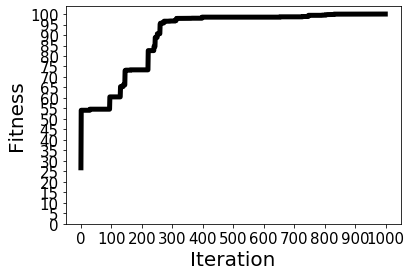

In [16]:
pop_weights_mat = vector_to_mat(pop_weights_vector, pop_weights_mat)
best_weights = pop_weights_mat [0, :]
acc, predictions = pred(best_weights, data_inputs, data_outputs, act="sigmoid")
print("Accuracy of the best solution is : ", acc)

matplotlib.pyplot.plot(accuracies, linewidth=5, color="black")
matplotlib.pyplot.xlabel("Iteration", fontsize=20)
matplotlib.pyplot.ylabel("Fitness", fontsize=20)
matplotlib.pyplot.xticks(np.arange(0, num_generations+1, 100), fontsize=15)
matplotlib.pyplot.yticks(np.arange(0, 101, 5), fontsize=15)

f = open("weights_"+str(num_generations)+"_iterations_"+str(mutation_percent)+"%_mutation.pkl", "wb")
pickle.dump(pop_weights_mat, f)
f.close()